<a href="https://colab.research.google.com/github/DavoodSZ1993/pytorch_tutorial/blob/master/06_transfer_newtworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from torchvision.datasets.utils import download_url

In [2]:
download_url('https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet.tgz', '.')

  0%|          | 0/811706944 [00:00<?, ?it/s]

In [3]:
import tarfile

with tarfile.open('./oxford-iiit-pet.tgz', 'r:gz') as tar:
  tar.extractall(path='./data')

In [4]:
import os

DATA_DIR = './data/oxford-iiit-pet/images'

files = os.listdir(DATA_DIR)
files[:5]

['japanese_chin_75.jpg',
 'havanese_103.jpg',
 'Maine_Coon_176.jpg',
 'saint_bernard_186.jpg',
 'english_cocker_spaniel_168.jpg']

In [5]:
def parse_breed(fname):
  parts = fname.split('_')
  return ''.join(parts[:-1])

In [6]:
parse_breed(files[10])

'saintbernard'

In [7]:
from PIL import Image

def open_image(path):
  with open(path, 'rb') as f:
    img = Image.open(f)
    return img.convert('RGB')

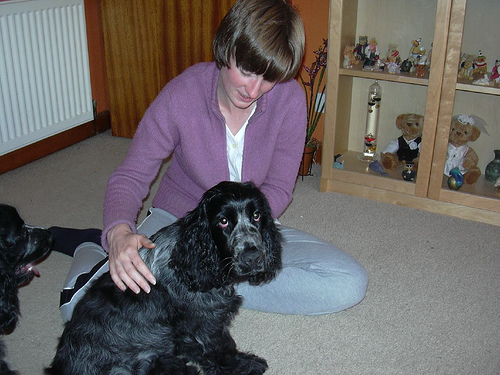

In [ ]:
open_image(os.path.join(DATA_DIR, files[4]))

In [8]:
import os
from torch.utils.data import Dataset

class PetsDataset(Dataset):
  def __init__(self, root, transform):
    super().__init__()
    self.root = root
    self.files = [fname for fname in os.listdir(root) if fname.endswith('.jpg')]
    self.classes = list(set(parse_breed(fname) for fname in files))
    self.transform = transform

  def __len__(self):
    return len(self.files)

  def __getitem__(self, i):
    fname = self.files[i]
    fpath = os.path.join(self.root, fname)
    img = self.transform(open_image(fpath))
    class_idx = self.classes.index(parse_breed(fname))
    return img, class_idx

In [11]:
import torchvision.transforms as T

img_size = 224
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
dataset = PetsDataset(DATA_DIR, T.Compose([T.Resize(img_size),
                                           T.Pad(8, padding_mode='reflect'),
                                           T.RandomCrop(img_size),
                                           T.ToTensor(),
                                           T.Normalize(*imagenet_stats)]))

In [14]:
len(dataset.classes)


37

In [17]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

def denormalize(images, means, stds):
  if len(images.shape) == 3:
    images = images.unsqueeze(0)
  means = torch.tensor(means).reshape(1, 3, 1, 1)
  stds = torch.tensor(stds).reshape(1, 3, 1, 1)
  return images * stds + means

def show_image(img_tensor, label):
  print('Label: ', dataset.classes[label], '(' + str(label) + ')')
  img_tensor = denormalize(img_tensor, *imagenet_stats)[0].permute((1, 2, 0))
  plt.imshow(img_tensor)

Label:  saintbernard (3)


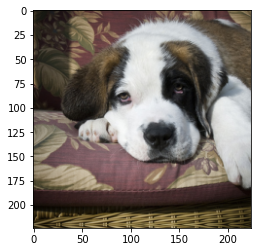

In [24]:
show_image(*dataset[10])

In [25]:
from torch.utils.data import random_split

In [26]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))

train_ds, valid_ds = random_split(dataset, [len(dataset) - val_size, val_size])

In [28]:
from torch.utils.data import DataLoader
batch_size = 256

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=2, pin_memory=True)

In [29]:
from torchvision.utils import make_grid

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(16,16))
    ax.set_xticks([]), ax.set_yticks([])
    images = denormalize(images[:64], *imagenet_stats)
    ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
    break

([<matplotlib.axis.XTick at 0x7f46647a7590>],
 [<matplotlib.axis.YTick at 0x7f466439ab90>])

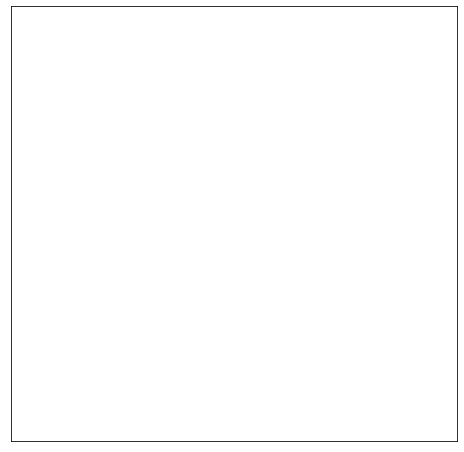

In [40]:
fig, ax = plt.subplots(figsize=(8,8))


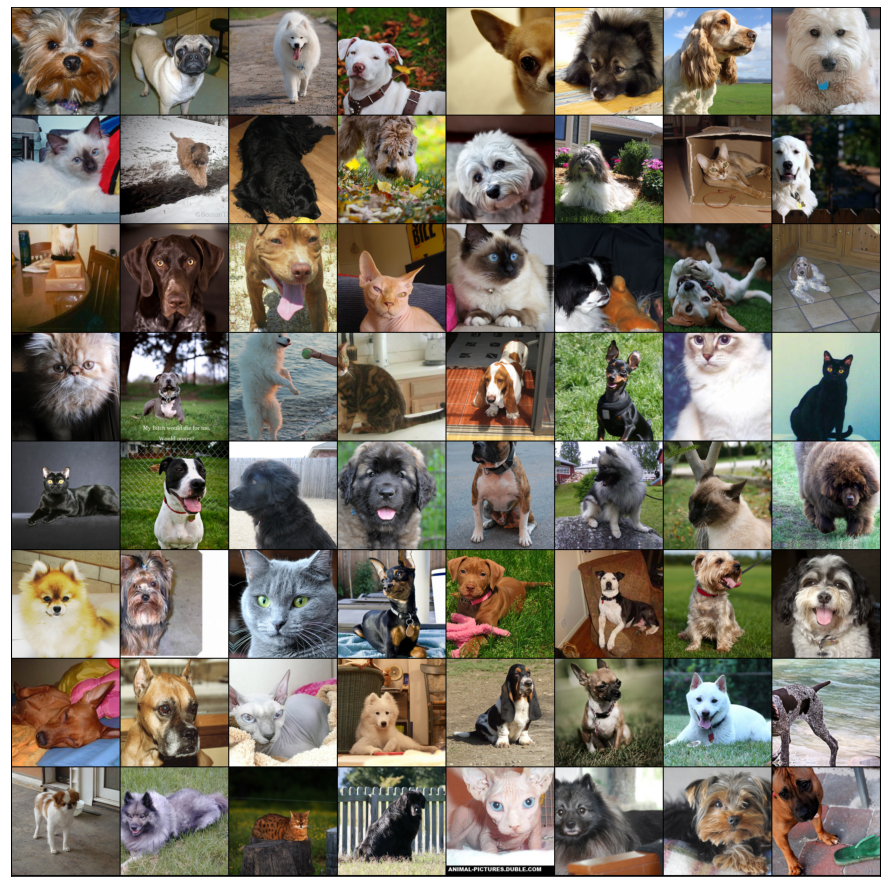

In [30]:
show_batch(train_dl)